## Preliminary explorations of DEXTR

https://cvlsegmentation.github.io/dextr/

None of these worked. Will revisit if there's more time.

In [ ]:
!pip install ruamel.yaml

     |████████████████████████████████| 109 kB 5.6 MB/s 
     |████████████████████████████████| 546 kB 35.6 MB/s 


In [ ]:
# From https://gist.github.com/pemagrg1/f959c19ec18fee3ce2ff9b3b86b67c16

import ruamel.yaml

repodir = 'DEXTR-AnnoTool'
yaml = ruamel.yaml.YAML()
data = yaml.load(open('{}/conda_env.yml'.format(repodir)))

requirements = []
for dep in data['dependencies']:
    if isinstance(dep, str):
        package, package_version, python_version = dep.split('=')
        if python_version == '0':
            continue
        requirements.append(package + '==' + package_version)
    elif isinstance(dep, dict):
        for preq in dep.get('pip', []):
            requirements.append(preq)

with open('{}/requirements.txt'.format(repodir), 'w') as fp:
    for requirement in requirements:
       print(requirement, file=fp)

# DEXTR-AnnoTool

In [ ]:
!git clone https://github.com/karan-shr/DEXTR-AnnoTool.git

Cloning into 'DEXTR-AnnoTool'...
remote: Enumerating objects: 120, done.
remote: Total 120 (delta 0), reused 0 (delta 0), pack-reused 120
Receiving objects: 100% (120/120), 2.40 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
%%bash
cd DEXTR-AnnoTool/models/
chmod +x download_dextr_model.sh
./download_dextr_model.sh
cd ..

--2022-05-02 03:00:15--  https://data.vision.ee.ethz.ch/csergi/share/DEXTR/dextr_pascal-sbd.h5
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196469468 (187M)
Saving to: ‘dextr_pascal-sbd.h5’

     0K .......... .......... .......... .......... ..........  0%  224K 14m18s
    50K .......... .......... .......... .......... ..........  0%  450K 10m42s
   100K .......... .......... .......... .......... ..........  0%  447K 9m31s
   150K .......... .......... .......... .......... ..........  0% 48.9M 7m9s
   200K .......... .......... .......... .......... ..........  0% 65.8M 5m44s
   250K .......... .......... .......... .......... ..........  0% 78.2M 4m47s
   300K .......... .......... .......... .......... ..........  0%  454K 5m6s
   350K .......... .......... .......... ........

In [ ]:
%%bash
cd DEXTR-AnnoTool/
sed 's/import tensorflow as tf/import tensorflow\.compat\.v1 as tf\ntf\.disable_v2_behavior()/' annotate.py > jus.py

In [ ]:
%%bash
cd DEXTR-AnnoTool/
python jus.py -c anno_cfg.yml

In config file 'update: True', so source folder will be scanned again and new files will be added to progress tracking cache.
Building network based on ResNet 101 and PSP module expecting inputs of shape (512, 512) predicting 1 classes
PSP module will interpolate to a final feature map size of (64, 64)


Instructions for updating:
non-resource variables are not supported in the long term
2022-05-02 03:05:20.948459: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Instructions for updating:
Colocations handled automatically by placer.
Traceback (most recent call last):
  File "jus.py", line 56, in <module>
    num_input_channels=4, classifier='psp', sigmoid=True)
  File "/content/DEXTR-AnnoTool/networks/dextr.py", line 22, in __init__
    input_shape=self.input_shape, classifier=classifier, sigmoid=self.sigmoid, output_size=self.input_shape)
  File "/content/DEXTR-AnnoTool/networks/resnet.py", line 166, in build_network
    x = build_pyramid_pooling_module(res, input_shape, nb_classes, sigmoid=sigmoid, output_size=output_size)
  File "/content/DEXTR-AnnoTool/networks/classifiers.py", line 78, in build_pyramid_pooling_module
    interp_block1 = psp_block(res, 1, feature_map_size, input_shape)
  File "/co

In [ ]:
import sys
sys.path.append('/content/DEXTR-AnnoTool')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/DEXTR-AnnoTool']

In [ ]:
import argparse
from os import path

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Button

import tensorflow as tf
from keras import backend as K

# ---user-defined modules---
# repo defined
from networks.dextr import DEXTR
from mypath import Path
from helpers import helpers as helpers
from helpers import annotools as tools

modelName = 'dextr_pascal-sbd'
pad = 50
thres = 0.8
gpu_id = 0
rootdir = '/content/DEXTR-AnnoTool'

In [ ]:
!ln -s $rootdir/sample_images ./sample_images

In [ ]:
# ---------------------------------Setting up based on yaml config--------------------------------------------------
configfile = '{}/anno_cfg.yml'.format(rootdir)
cfg = tools.load_config(configfile)
cfg, files_to_annotate = tools.config_prog_log(cfg, configfile)

In config file 'update: True', so source folder will be scanned again and new files will be added to progress tracking cache.


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
import tensorflow as tf

In [ ]:
## ------------------------------------Setup TensorFlow session------------------------------------------------------
## Handle input and output args
#sess = tf.Session()
#K.set_session(sess)
#
#with sess.as_default():

In [ ]:
net = DEXTR(nb_classes=1, resnet_layers=101, input_shape=(512, 512), weights=modelName,
            num_input_channels=4, classifier='psp', sigmoid=True)

In [ ]:
!find DEXTR-AnnoTool -exec grep -s resize_images {} \; -print

In [ ]:
%%bash
sourcefile=/content/DEXTR-AnnoTool/networks/classifiers.py
targetfile=/tmp/jus.py
sed 's/ktf\.image\.resize_images/ktf\.image\.resize/' $sourcefile > $targetfile
mv $targetfile $sourcefile
!rm -rf /content/DEXTR-AnnoTool/networks/__pycache__

In [ ]:
net = DEXTR(nb_classes=1, resnet_layers=101, input_shape=(512, 512), weights=modelName,
            num_input_channels=4, classifier='psp', sigmoid=True)

Building network based on ResNet 101 and PSP module expecting inputs of shape (512, 512) predicting 1 classes
PSP module will interpolate to a final feature map size of (64, 64)


TypeError: ignored

In [ ]:
# -----------------------------------Start annotation interface-------------------------------------------------
_KEEPannotating = True  # annotation status flag

# Initialise the UI
plt.switch_backend('TkAgg')  # force 'TkAgg' backend
ui = plt.figure('Annotation Interface')
manager = plt.get_current_fig_manager()
manager.resize(*manager.window.maxsize()) # maximize window
plt.ion()  # setup interactive mode

for filename in files_to_annotate:

    if _KEEPannotating:

        # read image
        imagepath = path.join(cfg['required']['source'], filename)
        image = np.array(Image.open(imagepath))

        # image level status flags
        _ANNOinit = False
        _lastANNOwrong = False
        _SKIP_IMAGE = False

        # -----Setup figure for annotating -----
        ui.clear()

        gs = ui.add_gridspec(2, 2, width_ratios=[5, 1], height_ratios=[11, 1])
        # setup window for images
        ui_img = ui.add_subplot(gs[0])
        ui_img.axis('off')
        ui_img.imshow(image)
        # window for annotation instructions
        ui_instruct = ui.add_subplot(gs[1], sharex=ui_img, sharey=ui_img)
        ui_instruct.axis('off')
        instruct_msg = ui_instruct.text(0, 0,
                                        'Instructions:\n'
                                        '1. Use the left mouse button to select the\n'
                                        'following four extreme points for an object:\n'
                                        '- left,\n'
                                        '- right,\n'
                                        '- top, and\n'
                                        '- bottom.\n\n'
                                        '2. In case of misselection, use right mouse\n'
                                        'button to undo.\n\n'
                                        '3. When the 4 points are selected, the\n'
                                        'resulting masks are overlayed.\n\n'
                                        '4. Status messages are displayed at bottom\n'
                                        'of the image; provide input based on them.\n\n'
                                        '5. Close window to exit.',
                                        fontsize=12, wrap=True, va='top', ha='left')
        # window for displaying status
        ui_status = ui.add_subplot(gs[2], sharey=ui_img)  # window for displaying status
        ui_status.axis('off')

        # hold predictions from image
        image_results = []

        # keep running till user says he had finished annotating all objects in an image
        while True:

            if not _ANNOinit:
                ui_msg = ui_status.text(0, 0, 'Start annotation...', color='green', wrap=True, fontsize=14,
                                        va='top', ha='left')
                _ANNOinit = True

            elif _ANNOinit:
                if not _lastANNOwrong:
                    ui_msg = ui_status.text(0, 0, 'Continue annotation...', color='green', wrap=True,
                                            fontsize=14, va='top', ha='left')
                elif _lastANNOwrong:
                    ui_img.imshow(helpers.overlay_masks(image / 255, image_results))
                    ui_msg = ui_status.text(0, 0, 'Ok. try again...', color='green', wrap=True,
                                            fontsize=14, va='top', ha='left')


            # user input required
            extreme_points_ori = np.array(plt.ginput(4, timeout=0, mouse_add=1)).astype(np.int)

            ui_msg.remove()

            # Crop image to the bounding box from the extreme points and resize
            bbox = helpers.get_bbox(image, points=extreme_points_ori, pad=pad, zero_pad=True)
            crop_image = helpers.crop_from_bbox(image, bbox, zero_pad=True)
            resize_image = helpers.fixed_resize(crop_image, (512, 512)).astype(np.float32)

            # Generate extreme point heat map normalized to image values
            extreme_points = extreme_points_ori - [np.min(extreme_points_ori[:, 0]),
                                                    np.min(extreme_points_ori[:, 1])] + [pad, pad]
            extreme_points = (512 * extreme_points * [1 / crop_image.shape[1], 1 / crop_image.shape[0]]).astype(
                np.int)
            extreme_heatmap = helpers.make_gt(resize_image, extreme_points, sigma=10)
            extreme_heatmap = helpers.cstm_normalize(extreme_heatmap, 255)

            # Concatenate inputs and convert to tensor
            input_dextr = np.concatenate((resize_image, extreme_heatmap[:, :, np.newaxis]), axis=2)

            # Run a forward pass
            pred = net.model.predict(input_dextr[np.newaxis, ...])[0, :, :, 0]
            result = helpers.crop2fullmask(pred, bbox, im_size=image.shape[:2], zero_pad=True, relax=pad) > thres

            # Mask correct or not
            image_results.append(result)  # add result to list of results even if incorrect for vis purposes
            plot_mask = ui_img.imshow(helpers.overlay_masks(image / 255, image_results))

            if _lastANNOwrong:
                ui_msg = ui_status.text(0, 0, 'Is the mask now correct? Click left mouse for yes, press \'n\' '
                                              'for no.',
                                        color='orange', wrap=True, fontsize=14, va='top', ha='left')
                usr_choice = plt.waitforbuttonpress()
                if usr_choice:
                    ui_msg.remove()
                    ui_msg = ui_status.text(0, 0, 'Okay, to try annotating one more time click left mouse or '
                                                  'press \'n\' to skip to the new image.',
                                            color='red', wrap=True, fontsize=14, va='top', ha='left')
                    usr_choice_skip = plt.waitforbuttonpress()
                    if usr_choice_skip:
                        ui_msg.remove()
                        _SKIP_IMAGE = True
                        _lastANNOwrong = False
                        break
                    else:
                        ui_msg.remove()
                        wrong_anno_mask = image_results.pop()
                        _lastANNOwrong = True
                        continue
                else:
                    _lastANNOwrong = False
                    ui_msg.remove()
            else:
                ui_msg = ui_status.text(0, 0, 'Is the generated mask correct? Click left mouse for yes, press'
                                              ' \'r\' to redo.',
                                        color='orange', wrap=True, fontsize=14, va='top', ha='left')
                not_anno_correct = plt.waitforbuttonpress()
                ui_msg.remove()
                if not_anno_correct:
                    wrong_anno_mask = image_results.pop()
                    _lastANNOwrong = True
                    continue

            # Add extreme points to show annotation done for the object
            ui_img.plot(extreme_points_ori[:, 0], extreme_points_ori[:, 1], 'gx')
            # Check what user wants to do next
            ui_msg = ui_status.text(0, 0, 'Click left mouse to continue annotating this image or press \'d\''
                                          ' if done.',
                                    color='orange', wrap=True, fontsize=14, va='top', ha='left')
            usr_choice = plt.waitforbuttonpress()
            ui_msg.remove()

            if usr_choice:  # if user presses d then break
                ui_msg = ui_status.text(0, 0, 'Annotation of this image stopped, mask image saved and progress'
                                              ' updated',
                                        color='red', wrap=True, fontsize=14, va='top', ha='left')
                break

        if _SKIP_IMAGE:  # check if the break was initialised by skipping image
            tools.prog_update_skip(cfg, filename) # update prog file
            continue  # if so, then continue on to next image

        # Show and save the generated masks
        generated_mask = tools.get_img_segmasks(image, image_results)
        mask_uint8 = tools.save_mask(generated_mask, cfg, filename)

        # -----Setup figure for showing annotation results -----
        ui.clear()
        # update figure to show subplots
        gs_res = ui.add_gridspec(2, 2, height_ratios=[11, 1])
        # subplot-1: image
        ui_res_img = ui.add_subplot(gs_res[0])
        ui_res_img.axis('off')
        ui_res_img.imshow(image)
        ui_res_img.set_title('Original Image')
        # subplot-2: mask image
        ui_res_mask = ui.add_subplot(gs_res[1])
        ui_res_mask.axis('off')
        ui_res_mask.imshow(mask_uint8, cmap='gray')
        ui_res_mask.set_title('Mask Image\n Note: Mask value scaled to [0 255] for visualisation')
        # subplot-3: status message
        ui_res_status = ui.add_subplot(gs_res[2], sharey=ui_res_img)  # window for displaying status
        ui_res_status.axis('off')
        ui_res_msg = ui_res_status.text(0.0, 0.0, 'Annotate next image? Click left mouse for yes or press \'e\''
                                                  ' to exit annotation and resume later',
                                        color='orange', wrap=True, fontsize=14, va='top', ha='left')

        # user input required
        usr_choice = plt.waitforbuttonpress()
        if usr_choice:  # if user presses e then break
            _KEEPannotating = False
        ui_res_msg.remove()
    else:
        print("Annotation of images stopped. Your progress has been saved. Run script again to resume "
              "annotation. Exiting...")
        exit(0)

print("Well Done...Finished annotating all files in the source folder. Exiting...")


# DEXTR-KerasTensorflow

In [ ]:
!git clone https://github.com/scaelles/DEXTR-KerasTensorflow.git

Cloning into 'DEXTR-KerasTensorflow'...
remote: Enumerating objects: 60, done.
remote: Total 60 (delta 0), reused 0 (delta 0), pack-reused 60
Unpacking objects: 100% (60/60), done.


In [ ]:
!cp DEXTR-AnnoTool/models/dextr_pascal-sbd.h5 DEXTR-KerasTensorflow/models/

In [ ]:
import sys
sys.path.append('/content/DEXTR-KerasTensorflow')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/DEXTR-KerasTensorflow']

In [ ]:
!pip uninstall --yes opencv-python-headless 

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64


In [ ]:
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 8.9 MB/s 


In [ ]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K

import tensorflow as tf

from networks.dextr import DEXTR
from mypath import Path
from helpers import helpers as helpers

modelName = 'dextr_pascal-sbd'
pad = 50
thres = 0.8
gpu_id = 0
rootdir = '/content/DEXTR-KerasTensorflow'

In [ ]:
## Handle input and output args
#sess = tf.Session()
#K.set_session(sess)
#
#with sess.as_default():


In [ ]:
!find DEXTR-KerasTensorflow -exec grep -s align_corners {} \; -print
!rm -rf DEXTR-KerasTensorflow/networks/__pycache__

                                          align_corners=True)
DEXTR-KerasTensorflow/networks/classifiers.py


In [ ]:
!head -13 DEXTR-KerasTensorflow/networks/classifiers.py

from math import ceil

from keras.layers.merge import Concatenate, Add
from keras.layers import AveragePooling2D, ZeroPadding2D

from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Layer

from networks import resnet
import keras.backend as K
from tensorflow.compat.v1.keras.backend import tf as ktf



In [ ]:
%%bash
sourcefile=/content/DEXTR-KerasTensorflow/networks/classifiers.py
tmpfile=/tmp/jus.py
sed 's/from keras\.backend import tf as ktf/from tensorflow.compat.v1.keras.backend import tf as ktf/' $sourcefile > $tmpfile
mv $tmpfile $sourcefile

In [ ]:
import tensorflow.compat.v1 as tf

In [ ]:
import tensorflow.compat.v1.keras as keras

In [ ]:
net = DEXTR(nb_classes=1, resnet_layers=101, input_shape=(512, 512), weights=modelName,
            num_input_channels=4, classifier='psp', sigmoid=True)

Building network based on ResNet 101 and PSP module expecting inputs of shape (512, 512) predicting 1 classes
PSP module will interpolate to a final feature map size of (64, 64)


AttributeError: ignored

Text(0.5, 1.0, 'Click the four extreme points of the objects\nHit enter when done (do not close the window)')

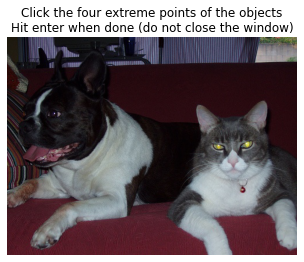

In [ ]:
#  Read image and click the points
image = np.array(Image.open('{}/ims/dog-cat.jpg'.format(rootdir)))
plt.ion()
plt.axis('off')
plt.imshow(image)
plt.title('Click the four extreme points of the objects\nHit enter when done (do not close the window)')

In [ ]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3335, done.
remote: Counting objects: 100% (3335/3335), done.
remote: Compressing objects: 100% (2761/2761), done.
remote: Total 3335 (delta 885), reused 1380 (delta 524), pack-reused 0
Receiving objects: 100% (3335/3335), 34.32 MiB | 27.54 MiB/s, done.
Resolving deltas: 100% (885/885), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
%%bash 
cd models/research
# The original notebook is broken: missing the following step of copying the setup.py
cp object_detection/packages/tf2/setup.py .
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1692480 sha256=5e2ed718c2d138a127b9ada36e29f1467e8a2de95b885e3d1cb33e4c5c245e25
  Stored in directory: /tmp/pip-ephem-wheel-cache-5_f3zmgn/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=6d80156e91528960a8c32f98c2719c4c610ba8c7a622fcb7598e429756f1276d
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=5a46efba729270db5ea205d24ac080da840b808e89871f609bed3598f35ce528
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44010 sha256=c7647490acef37ef9ec5d1b15f07bfce32dd17048b01a2d88b

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from object_detection.utils import colab_utils
from object_detection.utils import visualization_utils as viz_utils
box_storage_pointer = []

In [ ]:
image_path = '{}/ims/dog-cat.jpg'.format(rootdir)
im = Image.open(image_path)
height, width = im.size
im_np = np.array(im)
print(width, height, im_np.shape)
colab_utils.annotate([im_np], box_storage_pointer=box_storage_pointer)

375 500 (375, 500, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
print(box_storage_pointer)
print(width, height)
x1, x2 = (box_storage_pointer[0][:, 0]*width).astype(int)
x3, x4 = (box_storage_pointer[0][:, 2]*width).astype(int)
y1, y2 = (box_storage_pointer[0][:, 1]*height).astype(int)
y3, y4 = (box_storage_pointer[0][:, 3]*height).astype(int)

print(np.array([[x1, y1, x2, y2, x3, y3, x4, y4]]))

[array([[0.3071111 , 0.656     , 0.8571111 , 1.        ],
       [0.7971111 , 0.554     , 0.99877777, 0.742     ]])]
375 500
[[115 328 298 277 321 500 374 371]]


In [ ]:
extreme_points_ori = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
bbox = helpers.get_bbox(im, points=extreme_points_ori, pad=pad, zero_pad=True)
crop_image = helpers.crop_from_bbox(image, bbox, zero_pad=True)
resize_image = helpers.fixed_resize(crop_image, (512, 512)).astype(np.float32)

#  Generate extreme point heat map normalized to image values
extreme_points = extreme_points_ori - [np.min(extreme_points_ori[:, 0]), np.min(extreme_points_ori[:, 1])] + [pad,
                                                                                                              pad]
extreme_points = (512 * extreme_points * [1 / crop_image.shape[1], 1 / crop_image.shape[0]]).astype(np.int)
extreme_heatmap = helpers.make_gt(resize_image, extreme_points, sigma=10)
extreme_heatmap = helpers.cstm_normalize(extreme_heatmap, 255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [ ]:
#  Concatenate inputs and convert to tensor
input_dextr = np.concatenate((resize_image, extreme_heatmap[:, :, np.newaxis]), axis=2)

# Run a forward pass
pred = net.model.predict(input_dextr[np.newaxis, ...])[0, :, :, 0]
result = helpers.crop2fullmask(pred, bbox, im_size=image.shape[:2], zero_pad=True, relax=pad) > thres

results.append(result)

# Plot the results
plt.imshow(helpers.overlay_masks(image / 255, results))
plt.plot(extreme_points_ori[:, 0], extreme_points_ori[:, 1], 'gx')

NameError: ignored

# DEXTR-PyTorch